# Introduction to Flow Matching

In this notebook, we will implement a Flow Matching algorithm for image synthesis. This algorithm is closely linked to the more commonly known Diffusion Models algorithm, with the implementation of both being almost identical. In this lab work, we prefer to use Flow Matching, because the implementation is more straightforward.

**Goals:**


1.   Apply Flow Matching for generation of 2D data, in the case of Moons and Gaussian data
2.   Apply Flow Matching for generation of image data, in the case of mnist images

In [1]:
import argparse, os, random, math
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision import transforms,datasets
from torchvision import utils as vutils
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

In [2]:
print(torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"

True


## Part 1: Flow Matching for 2D data

In this part, we will implement a small MLP for carrying out Flow Matching.

First, we set up the model. This will have the following architecture:


- fully-connected, $d+1$ input neurons, $n_{hidden}$ output neurons, followed by ReLU
- fully-connected, $n_{hidden}$ input neurons, $n_{hidden}$ output neurons, followed by ReLU
- fully-connected, $n_{hidden}$ input neurons, $n_{hidden}$ output neurons, followed by ReLU
- fully-connected, $n_{hidden}$ input neurons, $d$ output neurons, followed by ReLU


The time step $t$ should be concatenated as an extra dimension to the data (making the input dimension of the data to be 3). We will set $n_{hidden}=64$.

In [3]:
class MLP_FM(nn.Module):

	def __init__(self, dim=1, n_hidden=64):
		super().__init__()
		d0 = dim + 1  # +1 for time map

		self.net = nn.Sequential(nn.Linear(d0,n_hidden),
		        nn.ReLU(),
						nn.Linear(n_hidden, n_hidden),
						nn.ReLU(),
						nn.Linear(n_hidden, n_hidden),
						nn.ReLU(),
						nn.Linear(n_hidden, dim),
						nn.ReLU())

	def forward(self, x_t, t):
			B = x_t.shape[0]
			t = t.view(B, 1)
			inp = torch.cat([x_t,t],dim = 1)
			return self.net(inp)
	 #FILL IN STUDENT



Now, we set up the necessary functions for Flow Matching. You will have to modify the following functions:
- ```coeffs_and_derivs```
- ```fm_training_step```

The first contains the coefficients $\alpha_t, \beta_t$ and derivatives $\dot{\alpha}_t,\dot{\beta}_t$ which correspond to the schedule of the interpolation (see lesson). Fill in these functions now.

In [4]:
def sample_prior_like(x):
	return torch.randn_like(x) #FILL IN STUDENT

def get_velocity(model, x_t, t):
	v_t = model(x_t, t)
	return v_t, x_t

# ---- schedules ----
def coeffs_and_derivs(t: torch.Tensor, schedule: str):
	if schedule == "linear":
		alpha_t = 1.0-t #FILL IN STUDENT
		beta_t = t #FILL IN STUDENT
		alpha_t_dot = -torch.ones_like(t) #FILL IN STUDENT
		beta_t_dot = torch.ones_like(t) #FILL IN STUDENT
		return alpha_t, beta_t, alpha_t_dot, beta_t_dot
	elif schedule == "cosine":
		half_pi_t = 0.5*math.pi*t #FILL IN STUDENT
		alpha_t = torch.cos(half_pi_t) #FILL IN STUDENT
		beta_t = torch.sin(half_pi_t) #FILL IN STUDENT
		alpha_t_dot = -(0.5 * math.pi) * torch.sin(half_pi_t)
		beta_t_dot = (0.5 * math.pi) * torch.cos(half_pi_t)
		return alpha_t, beta_t, alpha_t_dot, beta_t_dot
	else:
		raise ValueError(f"Unknown schedule: {schedule}")

def fm_training_step(model, x_0, x_1, device, schedule="linear"):
	B = x_1.size(0)
	x_0 = x_0.to(device)
	x_1 = x_1.to(device)
	t = torch.rand(B, device=device)
	alpha_t, beta_t, alpha_t_dot, beta_t_dot = coeffs_and_derivs(t, schedule)
	x_t = alpha_t[:, None] * x_0 + beta_t[:, None] * x_1
	v_t, _ = get_velocity(model, x_t, t)
	target = alpha_t_dot[:, None] * x_0 + beta_t_dot[:, None] * x_1

	loss = F.mse_loss(v_t, target)
	return loss


def sample_euler_trajectory(model, shape, steps=50, device="cuda"):
	model.eval()
	h = 1.0 / steps
	torch.manual_seed(123)
	x_t = torch.randn(shape,device=device)
	frames = []
	for k in range(steps):
		t = torch.full((shape[0],), (k + 0.5) / steps, device=device)
		v_t, _ = get_velocity(model, x_t, t)
		x_t = x_t + h * v_t
		frames.append(x_t)
	traj = torch.stack(frames, dim=0)
	traj = torch.permute(traj,(1,0,2)) # -> [B,n_steps, 2]
	return traj

@torch.no_grad()
def show_trajectory_2d(traj):
	B,n_steps,_ = traj.shape
	fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 3), sharex=True, sharey=True)
	print(traj.shape)
	axes[0].scatter( (traj.detach().cpu())[:,0, 0], (traj.detach().cpu())[:,0, 1], s=10)
	for i in range(0,n_steps):
		axes[i+1].scatter( (traj.detach().cpu())[:,i, 0], (traj.detach().cpu())[:,i, 1], s=10)
		axes[i+1].set_xlim(-4.0, 4.0)
		axes[i+1].set_ylim(-4.0, 4.0)
	plt.tight_layout()
	plt.show()

Now, we carry out the training itself. Fill in where necessary.

torch.Size([500, 10, 2])


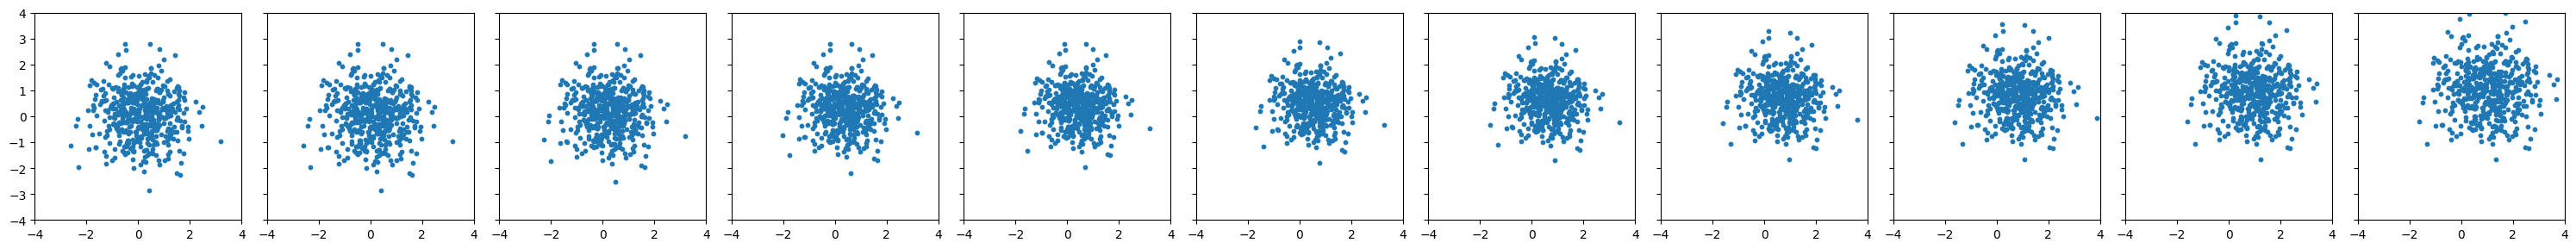

In [5]:
####################################
#######    HYPERPARAMETERS   #######
####################################

learning_rate = 1e-2
schedule = "linear"
n_hidden = 64
sample_every = 5000
batch_size = 256
steps_sampler = 10
n_samples = 500
n_iters = 5000

####################################
#########    ARCHITECTURE   ########
####################################

in_dim = 2
model = MLP_FM(dim=in_dim, n_hidden=n_hidden).to(device)

####################################
#########   TRAINING   ########
####################################

# optimiser
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

#training
for iteration in range(1, n_iters + 1):
  model.train()
  running = 0.0

  # data
  x_1 = 1 + torch.randn(batch_size, 2, device = device) #FILL IN STUDENT

  x_0 = sample_prior_like(x_1)

  opt.zero_grad()
  loss = fm_training_step(model,x_0=x_0,x_1=x_1,device=device,schedule=schedule)
  loss.backward()
  opt.step()

  if iteration % sample_every == 0:
    # traj : [B, n_steps, dim]
    traj = sample_euler_trajectory(
      model,
      shape=(n_samples,2),
      steps=steps_sampler,
      device=device
    )
    show_trajectory_2d( traj)

torch.Size([500, 10, 2])


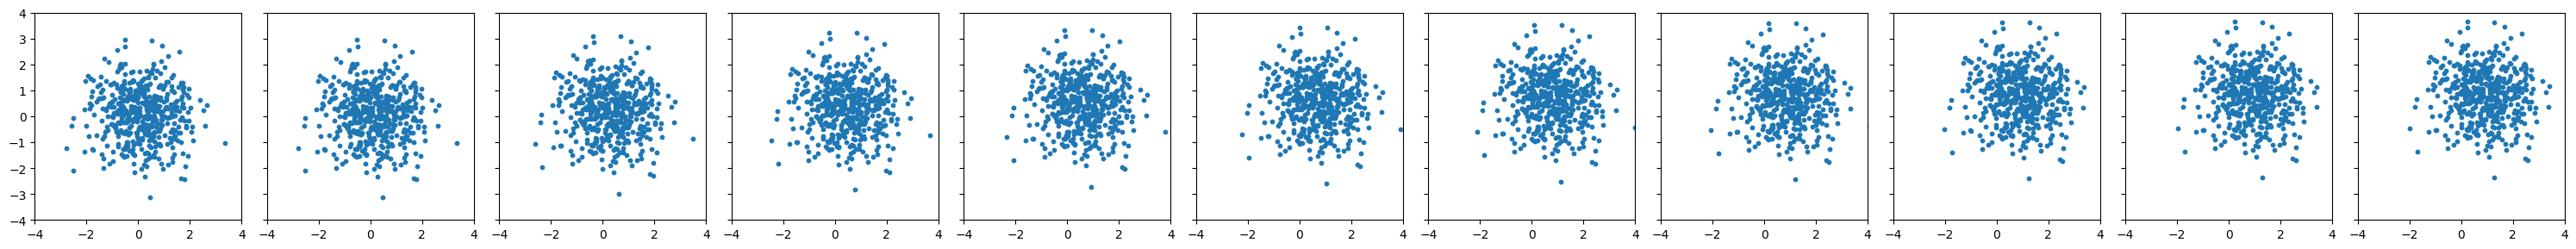

In [6]:
####################################
#######    HYPERPARAMETERS   #######
####################################

learning_rate = 1e-2
schedule = "cosine"
n_hidden = 64
sample_every = 5000
batch_size = 256
steps_sampler = 10
n_samples = 500
n_iters = 5000

####################################
#########    ARCHITECTURE   ########
####################################

in_dim = 2
model = MLP_FM(dim=in_dim, n_hidden=n_hidden).to(device)

####################################
#########   TRAINING   ########
####################################

# optimiser
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

#training
for iteration in range(1, n_iters + 1):
  model.train()
  running = 0.0

  # data
  x_1 = 1 + torch.randn(batch_size, 2, device = device) #FILL IN STUDENT

  x_0 = sample_prior_like(x_1)

  opt.zero_grad()
  loss = fm_training_step(model,x_0=x_0,x_1=x_1,device=device,schedule=schedule)
  loss.backward()
  opt.step()

  if iteration % sample_every == 0:
    # traj : [B, n_steps, dim]
    traj = sample_euler_trajectory(
      model,
      shape=(n_samples,2),
      steps=steps_sampler,
      device=device
    )
    show_trajectory_2d( traj)

## 1.2 Schedule comparison

In Flow Matching, the "schedule", ie the functions $\alpha_t$ and $\beta_t$ can affect the results. In this part, we will compare the "linear" schedule with the "cosine" schedule:
- Linear: $\alpha_t = 1-t$, $\beta_t = t$
- Cosine: ?

 First, we define a function to visualise the flow path.

In [7]:
def display_flow_path(traj):
	# traj : [B,n_steps,dim]
  B,n_steps,_ = traj.shape
  traj_np = traj.detach().cpu().numpy()
	# Plot the flow paths
  plt.figure(figsize=(8, 6))

  for i in range(0,B):
    plt.plot(traj_np[i,:,0], traj_np[i,:,1], marker="o", markersize=2, alpha=0.7)
    # special cases to show beginning and end
    plt.scatter(traj_np[i,0,0], traj_np[i,0,1], marker="*", alpha=0.7)
    plt.scatter(traj_np[i,-1,0], traj_np[i,-1,1], marker="^", alpha=0.7)


  plt.xlabel("X-axis")
  plt.ylabel("Y-axis")
  plt.title("Flow path")
	# xmin = -1.5
	# xmax = 1.5
	# ymin = -1.5
	# ymax = 1.5
	# plt.xlim(xmin, xmax)
	# plt.ylim(ymin, ymax)
  plt.axis('equal')
  plt.tight_layout()
  plt.show()

Now, train the model with the linear schedule and the cosine schedule, between two 2D Gaussian distributions, shifted by $(1,1)$, and compare. What do you observe?

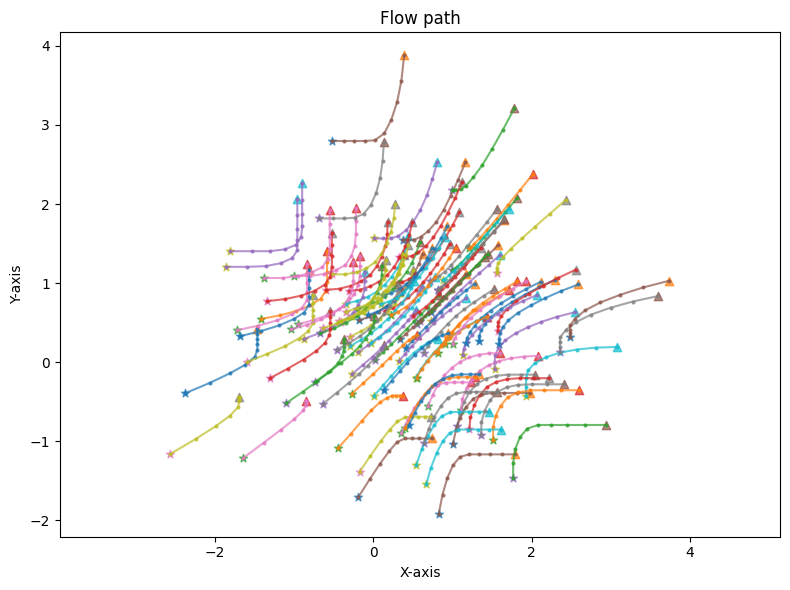

In [8]:
learning_rate = 1e-2
schedule = "linear"  # FILL IN STUDENT
n_hidden = 64
sample_every = 5000
batch_size = 256
steps_sampler = 10
n_samples = 100
n_iters = 5000

in_dim = 2
model = MLP_FM(dim=in_dim, n_hidden=n_hidden).to(device)

opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

for iteration in range(1, n_iters + 1):
  model.train()
  running = 0.0

  # data: N((1,1), I)
  x_1 = torch.randn(batch_size, 2, device=device) + torch.tensor([1.0, 1.0], device=device)

  x_0 = sample_prior_like(x_1)

  opt.zero_grad()
  loss = fm_training_step(model, x_0=x_0, x_1=x_1, device=device, schedule=schedule)
  loss.backward()
  opt.step()

  if iteration % sample_every == 0:
    traj = sample_euler_trajectory(
      model,
      shape=(n_samples, 2),
      steps=steps_sampler,
      device=device
    )
    display_flow_path(traj)


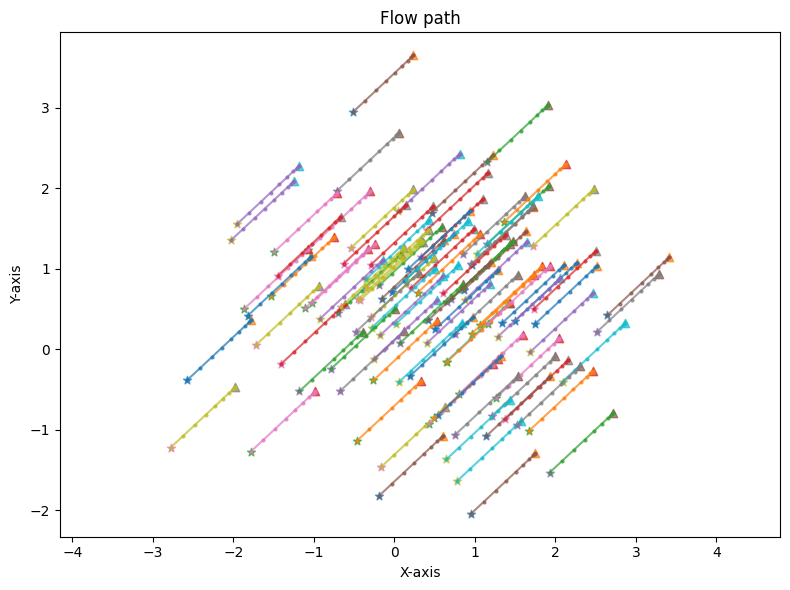

In [9]:
# WITH COSINE SCHEDULE
learning_rate = 1e-2
schedule = "cosine"  # FILL IN STUDENT
n_hidden = 64
sample_every = 5000
batch_size = 256
steps_sampler = 10
n_samples = 100
n_iters = 5000

in_dim = 2
model = MLP_FM(dim=in_dim, n_hidden=n_hidden).to(device)

opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

for iteration in range(1, n_iters + 1):
  model.train()
  running = 0.0

  # data: N((1,1), I)
  x_1 = torch.randn(batch_size, 2, device=device) + torch.tensor([1.0, 1.0], device=device)

  x_0 = sample_prior_like(x_1)

  opt.zero_grad()
  loss = fm_training_step(model, x_0=x_0, x_1=x_1, device=device, schedule=schedule)
  loss.backward()
  opt.step()

  if iteration % sample_every == 0:
    traj = sample_euler_trajectory(
      model,
      shape=(n_samples, 2),
      steps=steps_sampler,
      device=device
    )
    display_flow_path(traj)


## Part 2.1: images (mnist)

In this part, we will implement a U-Net for the case of mnist images.

The U-Net will have the following architecture:

## Input
- Input image  
  $x_t \in \mathbb{R}^{B \times 1 \times 28 \times 28}$
- Scalar time  
  $t \in \mathbb{R}^{B}$, expanded to a time map and concatenated:
  
  $$
  x_{\text{in}} = \mathrm{concat}(x_t,\; t\text{-map})
  \in \mathbb{R}^{B \times (2) \times 28 \times 28}
  $$

## Encoder
- **DoubleConv** $2 \rightarrow 32$ &nbsp; (28 × 28)
- **MaxPool** $2 \times 2$ &nbsp; (14 × 14)
- **DoubleConv** $32 \rightarrow 64$ &nbsp; (14 × 14)
- **MaxPool** $2 \times 2$ &nbsp; (7 × 7)

## Middle layer (Bottleneck)
- **DoubleConv** $64 \rightarrow 64$ &nbsp; (7 × 7)

## Decoder
- **TransposedConv** $64 \rightarrow 64$, kernel $2 \times 2$, stride 2 &nbsp; (14 × 14)
- Add skip connection from encoder feature map ($e_2$)
- **DoubleConv** $64 \rightarrow 32$ &nbsp; (14 × 14)
- **TransposedConv** $32 \rightarrow 32$, kernel $2 \times 2$, stride 2 &nbsp; (28 × 28)
- Add skip connection from encoder feature map ($e_1$)
- **DoubleConv** $32 \rightarrow 32$ &nbsp; (28 × 28)

## Output
- $1 \times 1$ convolution $c_1 \rightarrow C_{\text{out}}$
- Output tensor  
  $\in \mathbb{R}^{B \times C_{\text{out}} \times 28 \times 28}$

Again, the time step $t$ should be concatenated as an extra channel to the data, making the input number of channels to be 2). The ```DoubleConv'' layer is already implemented.

Implement this architecture now.

In [ ]:
# ----------------------------
# Model
# ----------------------------

import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(c_in, c_out, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(c_out, c_out, 3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class UNetModel(nn.Module):

    def __init__(self, in_channels=1, n_hidden=32, out_channels=1):
        super().__init__()
        c0 = in_channels + 1  # +1 for t-map
        c1, c2 = n_hidden, n_hidden * 2

        # Encoder
        self.enc1 = DoubleConv(c0, c1)            # 28x28
        self.down1 = nn.MaxPool2d(kernel_size=2)  # -> 14x14
        self.enc2 = DoubleConv(c1, c2)            # 14x14
        self.down2 = nn.MaxPool2d(kernel_size=2)  # -> 7x7

        # Bottleneck
        self.bott = DoubleConv(c2, c2)            # 7x7

        # Decoder (note: up2 outputs c2 so we can add with e2)
        self.up2  = nn.ConvTranspose2d(c2, c2, kernel_size=2, stride=2)  # 7->14
        self.dec2 = DoubleConv(c2, c1)                                   # after add, reduce to c1
        self.up1  = nn.ConvTranspose2d(c1, c1, kernel_size=2, stride=2)  # 14->28
        self.dec1 = DoubleConv(c1, c1)                                   # after add

        # Output
        self.out = nn.Conv2d(c1, out_channels, kernel_size=1)

    def forward(self, x_t, t):
        b, _, h, w = x_t.shape
        t = t.view(b, 1, 1, 1)
        tmap = t.expand(b, 1, h, w)
        x_in = torch.cat([x_t, tmap], dim=1)

        # Encoder
        e1 = self.enc1(x_in)        # (B, c1, 28, 28)
        p1 = self.down1(e1)         # (B, c1, 14, 14)

        e2 = self.enc2(p1)          # (B, c2, 14, 14)
        p2 = self.down2(e2)         # (B, c2, 7, 7)

        # Bottleneck
        btt = self.bott(p2)         # (B, c2, 7, 7)

        # Decoder with additive skips
        u2 = self.up2(btt)          # (B, c2, 14, 14)
        s2 = u2 + e2                # add skip
        d2 = self.dec2(s2)          # (B, c1, 14, 14)

        u1 = self.up1(d2)           # (B, c1, 28, 28)
        s1 = u1 + e1                # add skip
        d1 = self.dec1(s1)          # (B, c1, 28, 28)

        return self.out(d1)         # (B, out_channels, 28, 28)


We define some new tools for visualisation (code given):

In [ ]:
# ----------------------------
# Trajectory sampling tools
# ----------------------------

@torch.no_grad()
def save_trajectory_grid(traj):
	B,steps, C, H, W = traj.shape
	imgs = traj.reshape(B * steps, C, H, W)
	grid = vutils.make_grid(normalize_to_0_1(imgs), nrow=steps) #.clamp(0, 1)

	# Convert from (C, H, W) → (H, W, C)
	grid = grid.permute(1, 2, 0).cpu().numpy()

	plt.figure(figsize=(steps, B))
	plt.imshow(grid)
	plt.axis("off")
	plt.show()
	#vutils.save_image(grid, path)

def normalize_to_0_1(imgs: torch.Tensor) -> torch.Tensor:
	"""
	Normalize a batch of images to [0,1] range per image.
	imgs: (B, C, H, W)
	"""
	min_val = imgs.amin(dim=(1,2,3), keepdim=True)
	max_val = imgs.amax(dim=(1,2,3), keepdim=True)
	return (imgs - min_val) / (max_val - min_val + 1e-8)

Next, the data loader for mnist (code given). We have allowed to clip the size of the dataset for faster execution. Code given.

In [ ]:
def mnist_data_loader(data_root, image_size=28,batch_size=64,max_dataset_size=-1,shuffle=True):
	tfm = transforms.Compose([
		transforms.Resize(image_size),
		transforms.ToTensor(),
		transforms.Lambda(lambda x: x * 2.0 - 1.0) # normalise to (-1,1)
	])
	ds = datasets.MNIST(data_root, train=True, download=True, transform=tfm)
	if(max_dataset_size>0):
		ds = torch.utils.data.random_split(ds, [max_dataset_size, len(ds)-max_dataset_size])[0]
	dl = DataLoader(ds, batch_size=batch_size, shuffle=shuffle, num_workers=4, pin_memory=True)
	return dl

Now, we re-define the functions used for the Flow Matching. You will have to modify the following one:
- fm_training_step

The others stay the same or are given.


In [ ]:


def get_velocity(model, x_t, t):
	v_t = model(x_t, t)
	return v_t, x_t

def fm_training_step(model, x_0, x_1, device, schedule="linear"):
    B = x_1.size(0)
    x_0 = x_0.to(device)
    x_1 = x_1.to(device)
    t = torch.rand(B, device=device)

    a0, a1, a0_dot, a1_dot = coeffs_and_derivs(t, schedule)

    # reshape coefficients to broadcast over (C,H,W)
    a0 = a0.view(B, 1, 1, 1)
    a1 = a1.view(B, 1, 1, 1)
    a0_dot = a0_dot.view(B, 1, 1, 1)
    a1_dot = a1_dot.view(B, 1, 1, 1)

    x_t = a0 * x_0 + a1 * x_1                    # FILL IN STUDENT
    v_t, _ = get_velocity(model, x_t, t)

    target = a0_dot * x_0 + a1_dot * x_1         # FILL IN STUDENT

    loss = F.mse_loss(v_t, target)
    return loss


def sample_euler_trajectory(model, shape, steps=50, device="cuda"):
	model.eval()
	h = 1.0 / steps
	torch.manual_seed(123)
	x_t = torch.randn(shape,device=device)
	frames = []
	for k in range(steps):
		t = torch.full((shape[0],), (k + 0.5) / steps, device=device)
		v_t, _ = get_velocity(model, x_t, t)
		x_t = x_t + h * v_t
		frames.append(x_t)
	traj = torch.stack(frames, dim=0)
	traj = torch.permute(traj,(1,0,2,3,4)) # -> [B,n_steps, C, H , W]
	return traj

Finally, train and look at the results ! You should start to see reasonable (but not great) results around 50 epochs.

In [ ]:
####################################
#######    HYPERPARAMETERS   #######
####################################

learning_rate = 3e-4
schedule = "linear"
sample_every = 10
batch_size = 64
n_hidden = 32
steps_sampler = 20
n_samples = 4
n_epochs = 50
max_mnist_size = 7000

####################################
#########    DATASET SETUP   #######
####################################

data_root = "./data"
train_loader = mnist_data_loader(data_root, image_size=28,batch_size=64,max_dataset_size=max_mnist_size,shuffle=True)

####################################
#########    ARCHITECTURE   ########
####################################

in_channels = 1
out_channels = 1
model = UNetModel(in_channels=in_channels, n_hidden=n_hidden, out_channels=out_channels).to(device)

####################################
#########   TRAINING   ########
####################################

# optimiser
opt = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

#training
for epoch in range(1, n_epochs + 1):
  model.train()
  running = 0.0
  for x_1,_ in train_loader:
    x_0 = sample_prior_like(x_1)

    opt.zero_grad(set_to_none=True)
    loss = fm_training_step(model,x_0=x_0,x_1=x_1,device=device,schedule=schedule)
    loss.backward()
    opt.step()
    running += loss.item()
  print(f"[Epoch {epoch:03d}] loss={running/len(train_loader):.6f}")

  if epoch % sample_every == 0:
    traj = sample_euler_trajectory(
      model,
      shape=(n_samples,x_0.shape[1],x_0.shape[2],x_0.shape[3]),
      steps=steps_sampler,
      device=device
    )
    save_trajectory_grid(traj)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
####################################
#######    HYPERPARAMETERS   #######
####################################

learning_rate = 3e-4
schedule = "cosine"
sample_every = 10
batch_size = 64
n_hidden = 32
steps_sampler = 20
n_samples = 4
n_epochs = 50
max_mnist_size = 7000

####################################
#########    DATASET SETUP   #######
####################################

data_root = "./data"
train_loader = mnist_data_loader(data_root, image_size=28,batch_size=64,max_dataset_size=max_mnist_size,shuffle=True)

####################################
#########    ARCHITECTURE   ########
####################################

in_channels = 1
out_channels = 1
model = UNetModel(in_channels=in_channels, n_hidden=n_hidden, out_channels=out_channels).to(device)

####################################
#########   TRAINING   ########
####################################

# optimiser
opt = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

#training
for epoch in range(1, n_epochs + 1):
  model.train()
  running = 0.0
  for x_1,_ in train_loader:
    x_0 = sample_prior_like(x_1)

    opt.zero_grad(set_to_none=True)
    loss = fm_training_step(model,x_0=x_0,x_1=x_1,device=device,schedule=schedule)
    loss.backward()
    opt.step()
    running += loss.item()
  print(f"[Epoch {epoch:03d}] loss={running/len(train_loader):.6f}")

  if epoch % sample_every == 0:
    traj = sample_euler_trajectory(
      model,
      shape=(n_samples,x_0.shape[1],x_0.shape[2],x_0.shape[3]),
      steps=steps_sampler,
      device=device
    )
    save_trajectory_grid(traj)

Output hidden; open in https://colab.research.google.com to view.

## Part 2.2 Image-to-image translation

In this part, we will convert images between the two following domains:
- Fashion mnist (grey-scale images of clothes)
- mnist

First, we provide the Fashion mnist data loader:

In [ ]:
def fashion_mnist_data_loader(data_root, image_size=28,batch_size=64,max_dataset_size=-1,shuffle=True):
	tfm = transforms.Compose([
		transforms.Resize(image_size),
		transforms.ToTensor(),
		transforms.Lambda(lambda x: x * 2.0 - 1.0) # normalise to (-1,1)
	])
	ds = datasets.FashionMNIST(data_root, train=True, download=True, transform=tfm)
	if(max_dataset_size>0):
		ds = torch.utils.data.random_split(ds, [max_dataset_size, len(ds)-max_dataset_size])[0]
	dl = DataLoader(ds, batch_size=batch_size, shuffle=shuffle, num_workers=4, pin_memory=True)
	return dl

Now, create a new trajectory sampling function to sample from the source distribution

In [ ]:
def sample_euler_trajectory_image_to_image(model, train_loader_source,n_samples=4, steps=50, device="cuda"):
	model.eval()
	h = 1.0 / steps
	torch.manual_seed(123)
	x_t,_ = next(iter(train_loader_source))
	x_t = x_t.to(device)[:n_samples,:]
	frames = []
	for k in range(steps):
		t = torch.full((x_t.shape[0],), (k + 0.5) / steps, device=device)
		v_t, _ = get_velocity(model, x_t, t)
		x_t = x_t + h * v_t
		frames.append(x_t)
	traj = torch.stack(frames, dim=0)
	traj = torch.permute(traj,(1,0,2,3,4)) # -> [B,n_steps, C, H , W]
	return traj

Finally, keeping the same hyper-parameters, modify the training code to carry out image-to-image translation.

In [ ]:
####################################
#######    HYPERPARAMETERS   #######
####################################

learning_rate = 3e-4
schedule = "linear"
sample_every = 10
batch_size = 64
n_hidden = 32
steps_sampler = 40
n_samples = 4
n_epochs = 200
max_mnist_size = 7000

####################################
#########    DATASET SETUP   #######
####################################

data_root = "./data"
train_loader_source = fashion_mnist_data_loader(data_root, image_size=28,batch_size=64,max_dataset_size=max_mnist_size,shuffle=True)
train_loader_target = mnist_data_loader(data_root, image_size=28,batch_size=64,max_dataset_size=max_mnist_size,shuffle=True)

####################################
#########    ARCHITECTURE   ########
####################################

in_channels = 1
out_channels = 1
model = UNetModel(in_channels=in_channels, n_hidden=n_hidden, out_channels=out_channels).to(device)

####################################
#########   TRAINING   ########
####################################

# optimiser
opt = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

#training
for epoch in range(1, n_epochs + 1):
  model.train()
  running = 0.0
  for (x_0,_), (x_1,_) in zip(train_loader_source, train_loader_target):

    opt.zero_grad(set_to_none=True)
    loss = fm_training_step(model,x_0=x_0,x_1=x_1,device=device,schedule=schedule)
    loss.backward()
    opt.step()
    running += loss.item()
  print(f"[Epoch {epoch:03d}] loss={running/len(train_loader_source):.6f}")

  if epoch % sample_every == 0:
    traj = sample_euler_trajectory_image_to_image(
      model,
      train_loader_source=train_loader_source,
      n_samples=n_samples,
      steps=steps_sampler,
      device=device
    )
    save_trajectory_grid(traj)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
####################################
#######    HYPERPARAMETERS   #######
####################################

learning_rate = 3e-4
schedule = "cosine"
sample_every = 10
batch_size = 64
n_hidden = 32
steps_sampler = 40
n_samples = 4
n_epochs = 200
max_mnist_size = 7000

####################################
#########    DATASET SETUP   #######
####################################

data_root = "./data"
train_loader_source = fashion_mnist_data_loader(data_root, image_size=28,batch_size=64,max_dataset_size=max_mnist_size,shuffle=True)
train_loader_target = mnist_data_loader(data_root, image_size=28,batch_size=64,max_dataset_size=max_mnist_size,shuffle=True)

####################################
#########    ARCHITECTURE   ########
####################################

in_channels = 1
out_channels = 1
model = UNetModel(in_channels=in_channels, n_hidden=n_hidden, out_channels=out_channels).to(device)

####################################
#########   TRAINING   ########
####################################

# optimiser
opt = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

#training
for epoch in range(1, n_epochs + 1):
  model.train()
  running = 0.0
  for (x_0,_), (x_1,_) in zip(train_loader_source, train_loader_target):

    opt.zero_grad(set_to_none=True)
    loss = fm_training_step(model,x_0=x_0,x_1=x_1,device=device,schedule=schedule)
    loss.backward()
    opt.step()
    running += loss.item()
  print(f"[Epoch {epoch:03d}] loss={running/len(train_loader_source):.6f}")

  if epoch % sample_every == 0:
    traj = sample_euler_trajectory_image_to_image(
      model,
      train_loader_source=train_loader_source,
      n_samples=n_samples,
      steps=steps_sampler,
      device=device
    )
    save_trajectory_grid(traj)

Output hidden; open in https://colab.research.google.com to view.